---
---

# Exploratory Data Analysis

---
---

_The assertions and methodologies outlined in this notebook are substantiated by referenced scientific studies detailed in the README file._

### Load libraries and Data

In [18]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
from extract_features import *
from visualize_audio import *
from data_manager import *
from load_config import *
from preprocess_data import *

Load constants from the constants.yaml file

In [19]:
constants = load_constants_from_yaml('../constants.yml')

SAMPLING_RATING = constants["SAMPLING_RATING"]
FRAME_LENGTH_ENERGY = constants["FRAME_LENGTH_ENERGY"]
THRESHOLD_PERCENTAGE = constants["THRESHOLD_PERCENTAGE"]
MIN_SILENCE_DURATION = constants["MIN_SILENCE_DURATION"]
HOP_LENGTH = constants["HOP_LENGTH"]

### Experimenting on some recording

getting our hands dirty with some experimentations

In [20]:
audio1, SAMPLING_RATING = librosa.load("../data/raw/recordings/korean2.mp3", sr=SAMPLING_RATING)
audio2, SAMPLING_RATING = librosa.load("../data/raw/recordings/french43.mp3", sr=SAMPLING_RATING)
audio3, SAMPLING_RATING = librosa.load("../data/raw/recordings/hindi2.mp3", sr=SAMPLING_RATING)

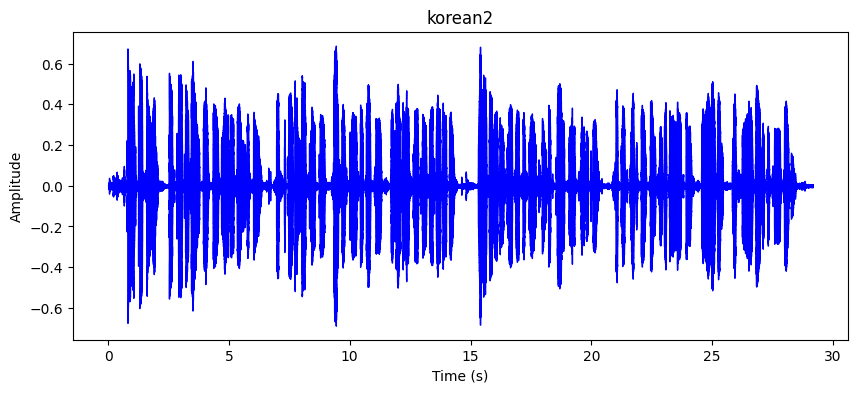

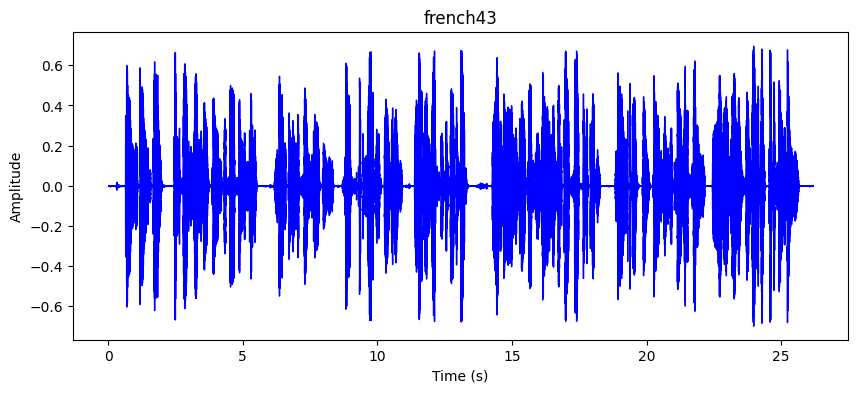

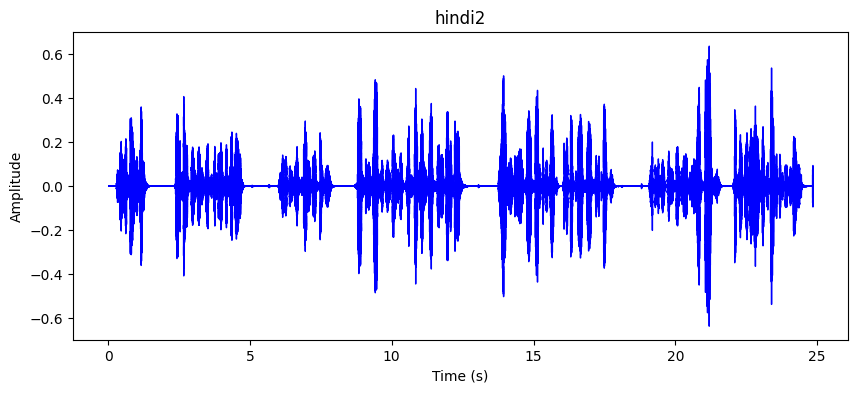

In [21]:
plot_audio(audio1, SAMPLING_RATING, title="korean2")
plot_audio(audio2, SAMPLING_RATING, title="french43")
plot_audio(audio3, SAMPLING_RATING, title="hindi2")

In [22]:
energy = librosa.feature.rms(y=audio1)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for 1st audio:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio2)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for 2nd audio:", round(100 * ratio, 2), "%")

energy = librosa.feature.rms(y=audio3)[0]
max_energy = max(energy)
threshold_energy = THRESHOLD_PERCENTAGE * max_energy
silent_segments = energy < threshold_energy
ratio = sum(silent_segments) / len(energy)
print("ratio of silent segments for 3th audio:", round(100 * ratio, 2), "%")

ratio of silent segments for 1st audio: 1.75 %
ratio of silent segments for 2nd audio: 15.25 %
ratio of silent segments for 3th audio: 24.0 %


---

This indicates that silence segments sometimes takes a big portion of the audio. Thus the need to trim it (remove silence parts) for various reasons.

It is worth noting that we aren't trying to make the ratio as close to 0% as possible as small "silence" frames/segments are part of the accent.

We would want to only remove any silence segment whenever the energy level was below 1.0% and it lasts more than 1 second.

Trimming silence serves two purposes :

- Common-causal variable: We don't want our model to predict the accent based on the silence parts, that could be only a result of people in certain regions in the world speak english less than others so they stutter more for example, we would like to a model that predict the accent only based on the phonems. So if the model was used later in a recording of an experienced non native english speaker (where in his born country/region english isn't quite common) the model should predicts the accent anyway.
- The second reason is to simply remove redundency in data. Even if the silent parts were equevalent between different accents, silence brings no additional info and it might as well cause overfitting in some cases.

Number of audible segments: 3


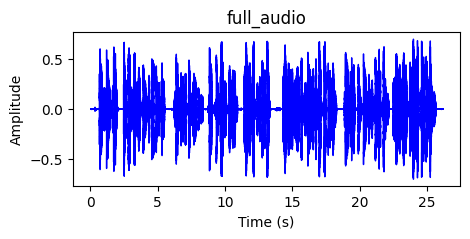

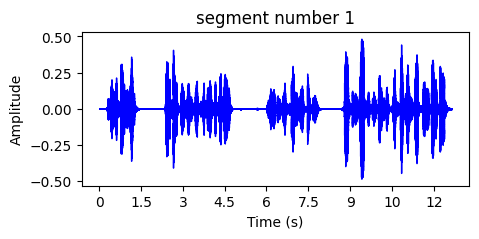

In [23]:
audible_segments = split_audio_by_silence(
    audio3,
    SAMPLING_RATING,
    threshold_percentage=THRESHOLD_PERCENTAGE,
    min_silence_duration=MIN_SILENCE_DURATION,
    frame_length_energy=FRAME_LENGTH_ENERGY,
    hop_length=HOP_LENGTH,
)
print("Number of audible segments:", len(audible_segments))
segment_index=0
segment=audible_segments[segment_index]
plot_audio(audio2, SAMPLING_RATING, title="full_audio", figsize=(5, 2))
plot_audio(segment, SAMPLING_RATING, title=f"segment number {segment_index+1}", figsize=(5, 2))

---

Unlike images, speech involves a dynamic process rather than a fixed pattern. Therefore, speech patterns are represented by feature vectors rather than singular ones. Given that accents are influenced by numerous factors, individuals may exhibit a blend of accents. It may be more effective to recognize accents at specific intervals rather than across the entire audio signal, prompting the use of signal segmentation. Research suggests that classifying brief segments of audio files can lead to more accurate accent identification. As such, audio recordings sampled at 22,050 Hz were divided into consecutive frames lasting 25 ms each, with a 10 ms overlap.

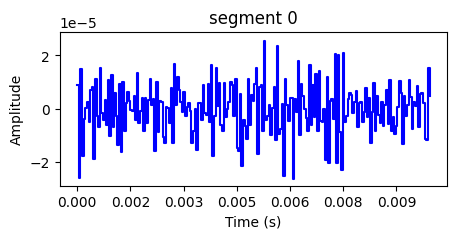

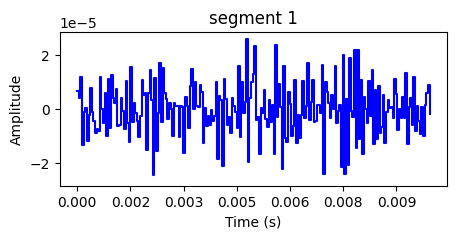

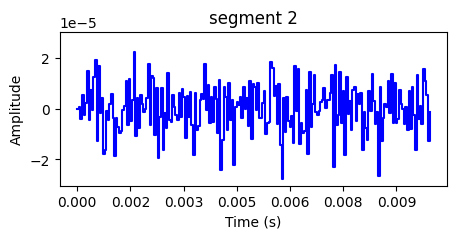

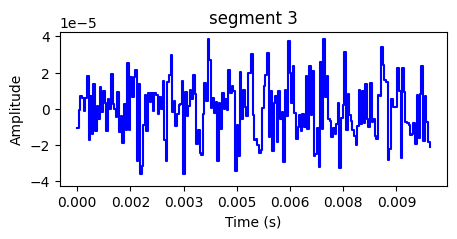

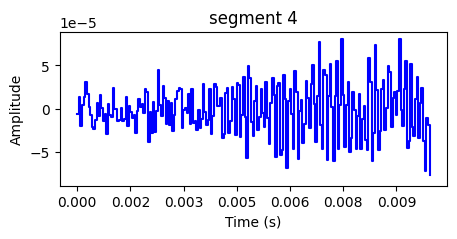

In [24]:
segments = segment_audio(audio2, sr=SAMPLING_RATING, duration=0.01, overlap=0.001)
for i, segment in enumerate(segments[:5]):
    plot_audio(segment, SAMPLING_RATING, title=f"segment {i}", figsize=(5, 2))

### Load all audio files with the corresponding labels (accents) 

In [25]:
audio_data, labels = load_audio_files("../data/raw/recordings/", sr=SAMPLING_RATING)
unique_labels=set(labels)
print(f'there are {len(unique_labels)} unique labels: {unique_labels}')
print(f'there are {len(audio_data)} audio files')

there are 5 unique labels: {'french', 'korean', 'english', 'hindi', 'arabic'}
there are 329 audio files


Visualize the number of recordings in each accent

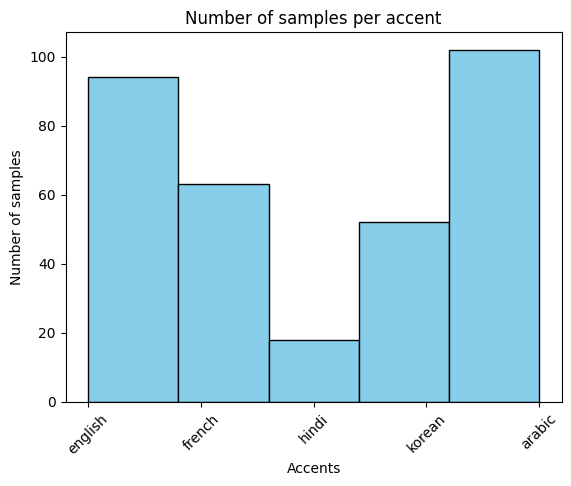

In [26]:
plt.hist(labels, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()

Hindi accent is under represented, for simplicity we would only consider arabic and english because they represent the bigger portion and they are equivalent in terms of the number of recordings.

In [27]:
CONSIDERED_ACCENTS=["english", "arabic"]

In [28]:
audio_data_filtered=[]
labels_filtered=[]

for i,audio in enumerate(audio_data):
    if labels[i] in CONSIDERED_ACCENTS:
        audio_data_filtered.append(audio)
        labels_filtered.append(labels[i])

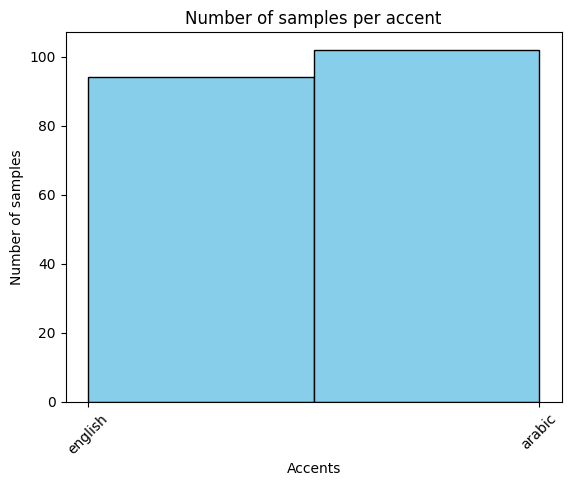

In [29]:
unique_labels=set(labels_filtered)
plt.hist(labels_filtered, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()

Trim silence part and store all segments as individual audios with the corresponding labels

In [30]:
audio_data_trimmed = []
labels_trimmed = []
for i, audio in enumerate(audio_data_filtered):
    audible_segments = split_audio_by_silence(
        audio,
        SAMPLING_RATING,
        threshold_percentage=THRESHOLD_PERCENTAGE,
        min_silence_duration=MIN_SILENCE_DURATION,
    )
    audio_data_trimmed.extend(audible_segments)
    labels_trimmed.extend([labels_filtered[i]] * len(audible_segments))

False


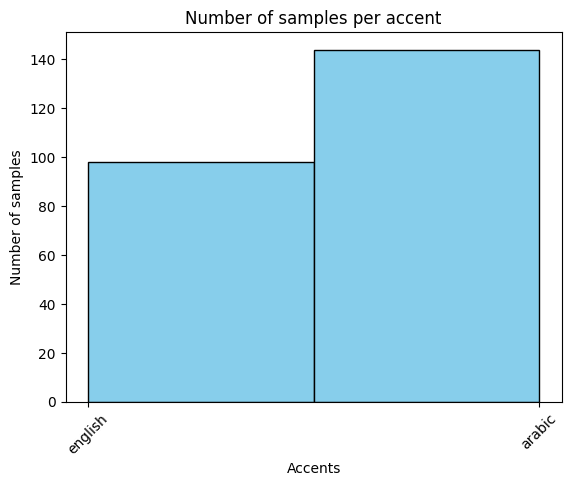

In [31]:
print(len(audio_data_trimmed)==len(audio_data))
plt.hist(labels_trimmed, bins=len(unique_labels), color='skyblue', edgecolor='black')
plt.xlabel('Accents')
plt.ylabel('Number of samples')
plt.title('Number of samples per accent')
plt.xticks(rotation=45)
plt.show()


The variance in sample counts can be attributed to the tendency of individuals from Arabic-speaking regions to pause between words. Despite the larger number of samples categorized under the Arabic label, they exhibit shorter durations. Nevertheless, we intend to conduct audio segmentation on these samples subsequently, despite their higher quantity but shorter duration.

---